In [ ]:
!pip install tensorflow[and-cuda]

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Reshape, concatenate, add, TimeDistributed, RepeatVector, Activation, Dot, Lambda
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

2024-08-28 03:35:21.309373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 03:35:21.309475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 03:35:21.432081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
image_path = '../input/my-shirt-dataset/data/Images'

In [10]:
data = pd.read_csv("../input/my-shirt-dataset/data/captions.csv")
data.head(30)

,image,caption
0,0.png,white long sleeve green bay shirt
1,0.png,long sleeve white green bay shirt
2,0.png,long sleeve shirt that says green bay
3,0.png,white long sleeve shirt that says green bay
4,1.png,multi colored long sleeve button up shirt
5,1.png,black red white and purple long sleeve button ...
6,1.png,long sleeve button up shirt with multiple colors
7,1.png,red white black and purple long sleeve button up
8,0.png,long sleeve green bay shirt
9,1.png,multi colored long sleeve button up


In [13]:
def read_img(path, img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = read_img(f"../input/my-shirt-dataset/data/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

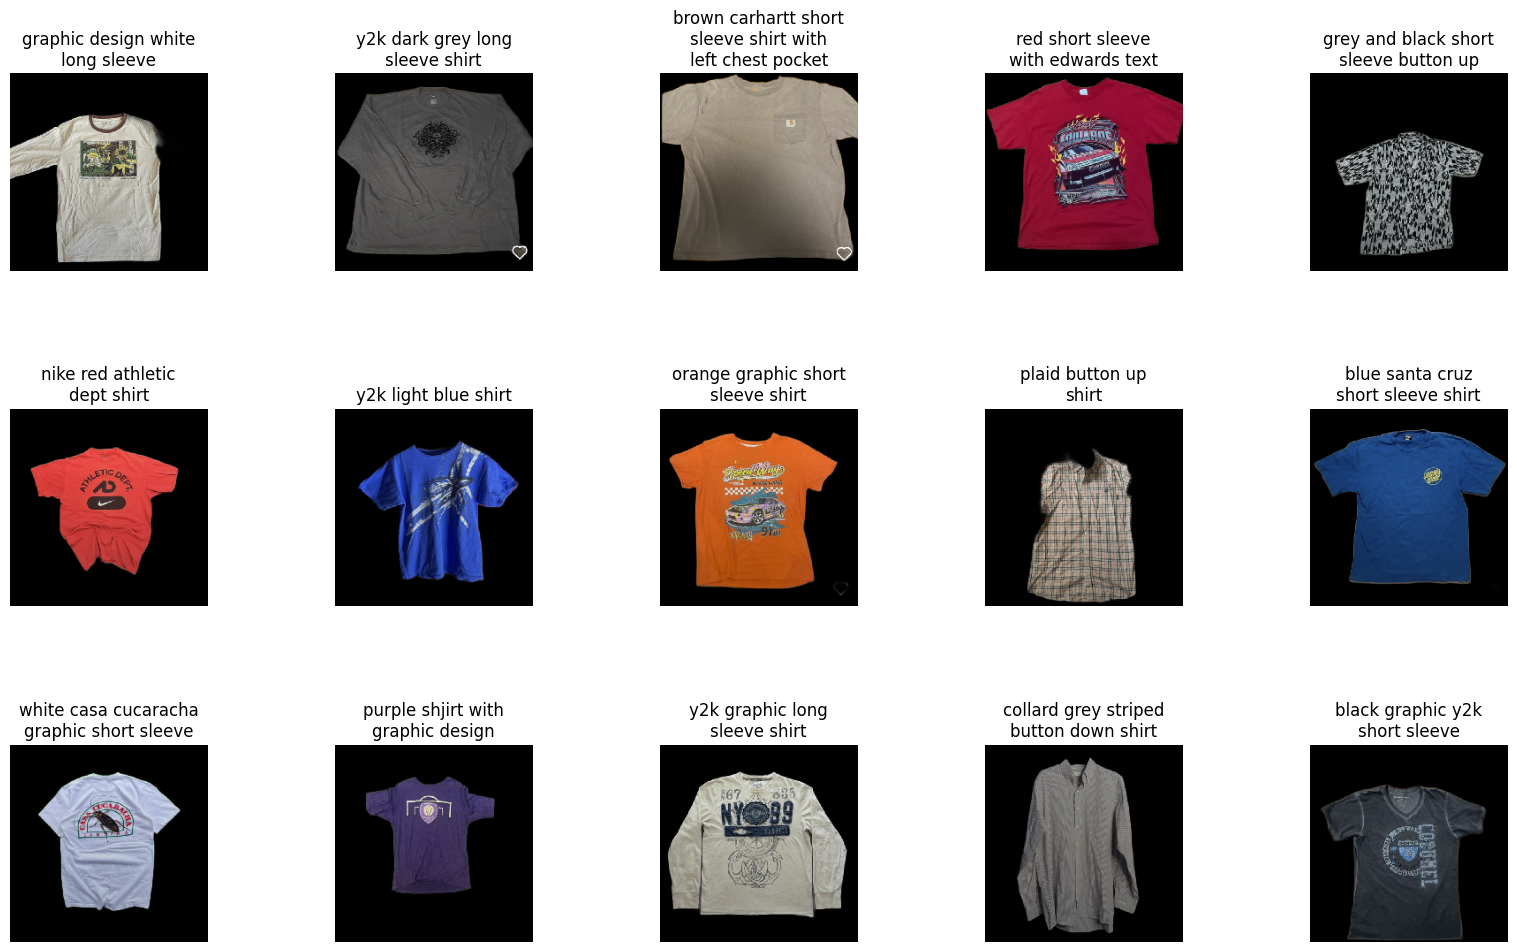

In [14]:
display_images(data.sample(15))

In [15]:
def text_preprocessing(data):
    try:
        data['caption'] = data['caption'].apply(lambda x: x.lower())
        data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
        data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
        data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
        data['caption'] = "startseq "+data['caption']+" endseq"
        return data
    except:
        print(data['caption'])

In [16]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq white long sleeve green bay shirt endseq',
 'startseq long sleeve white green bay shirt endseq',
 'startseq long sleeve shirt that says green bay endseq',
 'startseq white long sleeve shirt that says green bay endseq',
 'startseq multi colored long sleeve button up shirt endseq',
 'startseq black red white and purple long sleeve button up shirt endseq',
 'startseq long sleeve button up shirt with multiple colors endseq',
 'startseq red white black and purple long sleeve button up endseq',
 'startseq long sleeve green bay shirt endseq',
 'startseq multi colored long sleeve button up endseq']

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.9*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

print(captions[1])
tokenizer.texts_to_sequences([captions[1]])[0]

startseq long sleeve white green bay shirt endseq


[1, 7, 3, 10, 16, 117, 4, 2]

In [18]:
model = DenseNet201()
encoder = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
encodings = {}
encoding_val = []
encoding_image = []
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    encoding = encoder.predict(img, verbose=0)
    encoding_val.append(encoding)
    encoding_image.append(image)
    encodings[image] = encoding

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


  0%|          | 0/357 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1724816545.117606      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 357/357 [01:01<00:00,  5.81it/s]


In [19]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [184]:
from keras.losses import CategoricalCrossentropy

In [185]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Flatten, concatenate, add, RepeatVector, Activation, MultiHeadAttention, BatchNormalization
from tensorflow.keras.models import Model

# Define input shapes
input1 = Input(shape=(1920,))  # Image feature input
input2 = Input(shape=(max_length,))  # Sequence input

# Image feature processing
img_features = Dense(256, activation='relu')(input1)  # Adjusted units to 512 to match attention dimension
img_features = BatchNormalization()(img_features)
img_features = Dropout(0.5)(img_features)
img_features_flattened = Flatten()(img_features)
img_features_repeated = RepeatVector(max_length)(img_features_flattened)

# Sentence processing
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)  # Match the image feature dimension
sentence_features = Dropout(0.5)(sentence_features)

# Multi-Head Attention
attention = MultiHeadAttention(
    num_heads=8,  # Number of attention heads
    key_dim=256    # Dimension of the attention keys
)(query=sentence_features, value=img_features_repeated, key=img_features_repeated)

# Context vector computation
context = attention  # MultiHeadAttention output is already the context

# Merge context vector with sentence features
merged = concatenate([context, sentence_features])

# Sentence generation with Bidirectional LSTM
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)

# Combine with image features
x = add([x, img_features_flattened])  # Ensure dimensions match
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(vocab_size, activation='softmax')(x)

# Model definition
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1), optimizer='adam')



In [186]:
model_name = "/kaggle/working/model5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 20, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [187]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=encodings)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=encodings)

In [188]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 6.4106
Epoch 1: val_loss improved from inf to 5.71274, saving model to /kaggle/working/model5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 413ms/step - loss: 6.4050 - val_loss: 5.7127 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 5.6954
Epoch 2: val_loss improved from 5.71274 to 5.09379, saving model to /kaggle/working/model5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 5.6872 - val_loss: 5.0938 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 4.6981
Epoch 3: val_loss improved from 5.09379 to 4.21252, saving model to /kaggle/working/model5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 4.6893 - val_loss: 4.2125 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 3.8460
Epoch 4: val_loss improved from 4.21252 to 3.90275, saving model to /kaggle/working/model5.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 3.8413 - val_lo

In [165]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [166]:
image_names = os.listdir('../input/shirt-img')

In [197]:
def nucleus_sampling(predictions, p=.5):
    sorted_indices = np.argsort(predictions)[::-1]
    sorted_probs = predictions[sorted_indices]
    cumulative_probs = np.cumsum(sorted_probs)
    cutoff_index = np.where(cumulative_probs > p)[0][0]
    top_indices = sorted_indices[:cutoff_index + 1]
    top_probs = sorted_probs[:cutoff_index + 1]
    top_probs /= np.sum(top_probs)
    return np.random.choice(top_indices, p=top_probs)

def apply_temperature(predictions, temperature):
    predictions = np.log(predictions + 1e-10) / temperature  # Apply temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)  # Re-normalize probabilities
    return predictions

def get_caption(path, p=0.9,temperature=0.2):
    img = load_img(f'/kaggle/input/shirt-img/{path}', target_size=(224,224))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    encoding = encoder.predict(img, verbose=0)

    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = caption_model.predict([encoding,sequence], verbose=0)[0]
        
        y_pred = apply_temperature(y_pred, temperature)
        
        y_pred = nucleus_sampling(y_pred, p)


        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break
    
    return in_text[9:-7]

In [196]:
import keras
caption_model = keras.models.load_model('/kaggle/working/model5.keras')

In [198]:
def get_caption_default(path):
    img = load_img(f'/kaggle/input/shirt-img/{path}', target_size=(224,224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    encoding = encoder.predict(img, verbose=0)

    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = caption_model.predict([encoding, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break
    
    return in_text[9:-7]


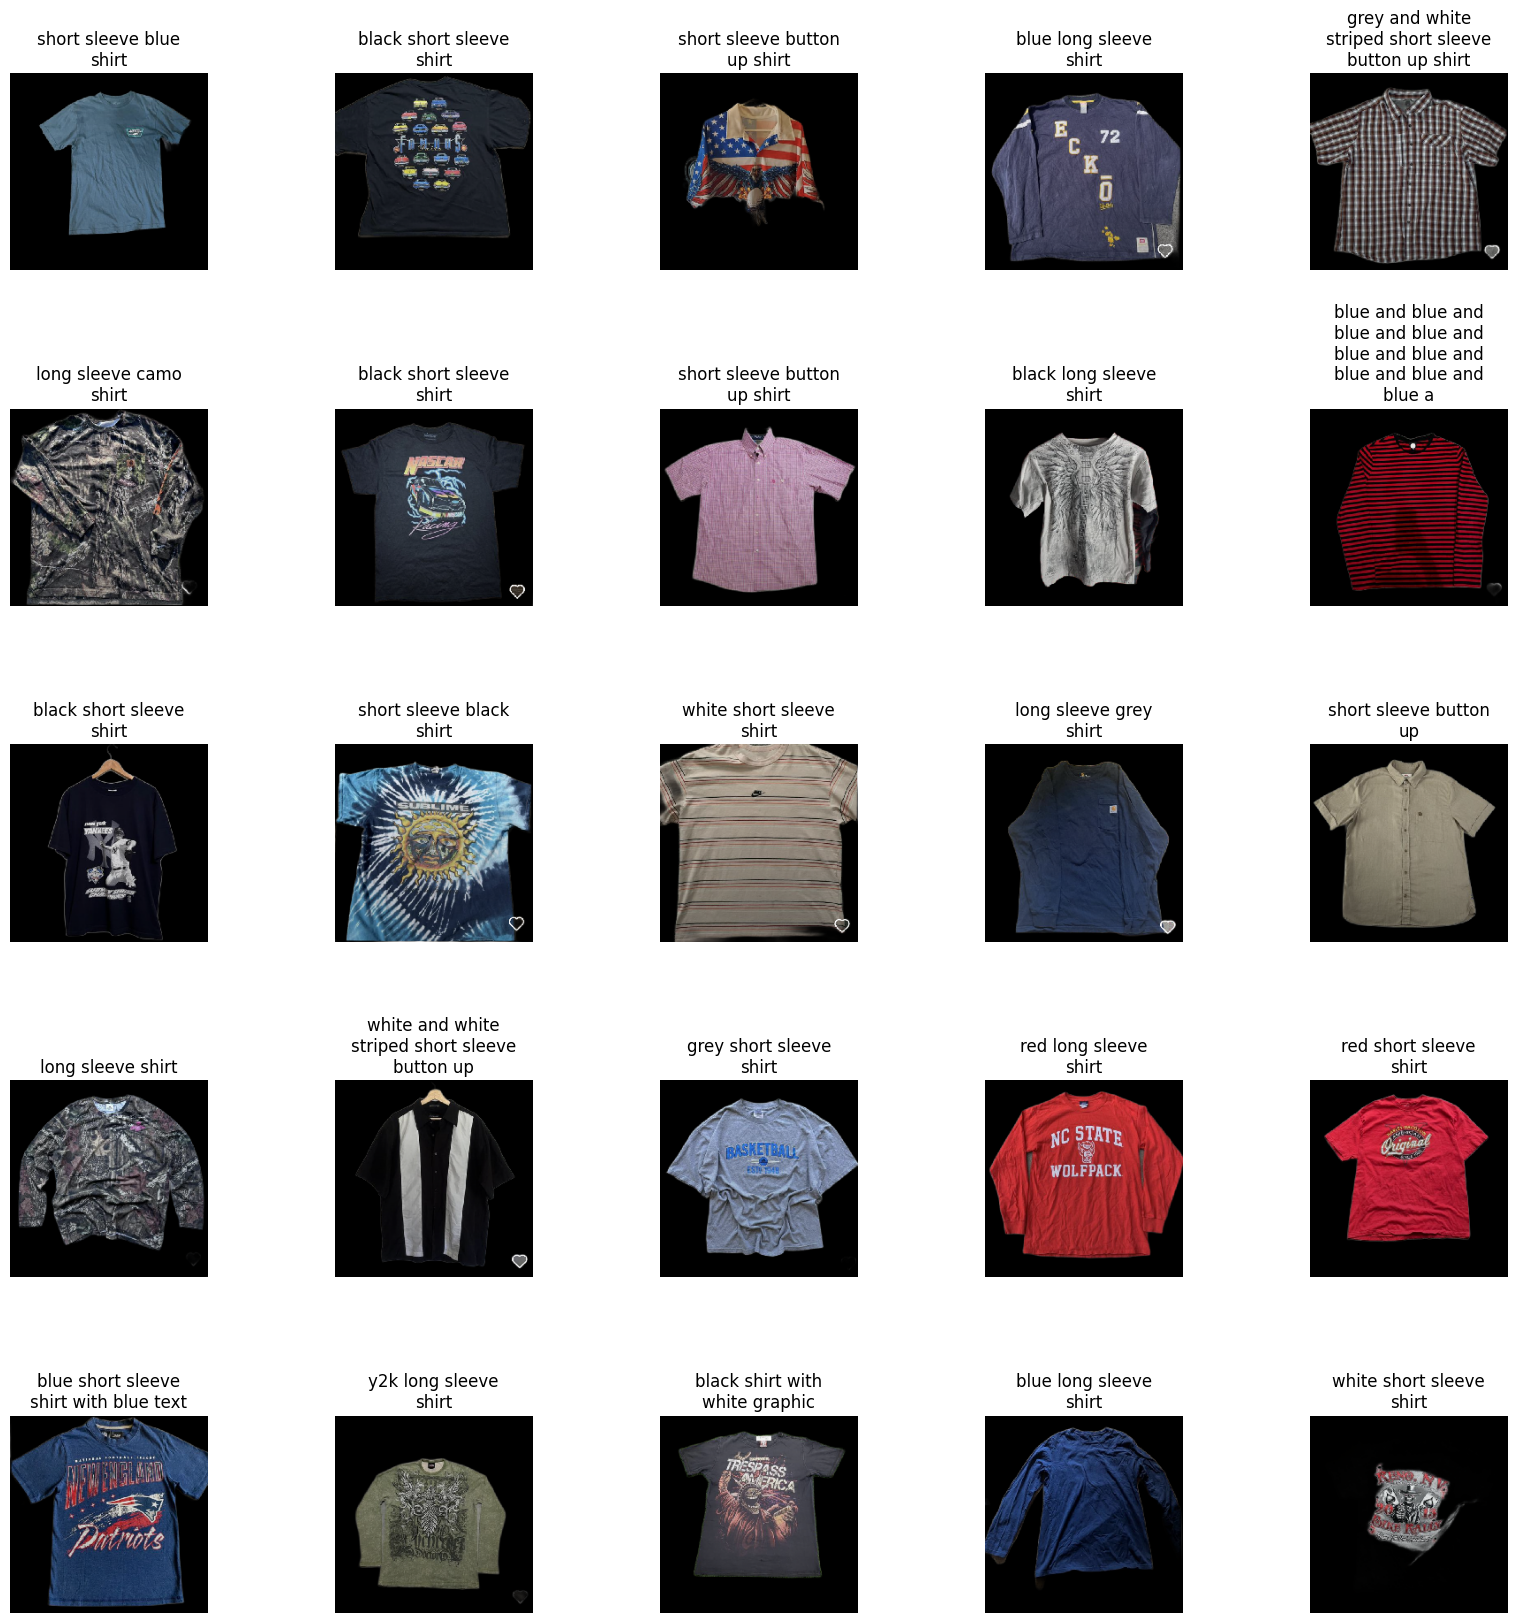

In [204]:
plt.figure(figsize = (20 , 20))
n = 1
for i in image_names:
    plt.subplot(5, 5, n)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    image = read_img(f"../input/shirt-img/{i}")
    plt.imshow(image)
    plt.title("\n".join(wrap(get_caption(i, p=0.9, temperature=.2), 20)))
#     plt.title("\n".join(wrap(get_caption_default(i), 20)))
    plt.axis("off")
    n+=1

In [206]:
import pickle

In [207]:
with open('/kaggle/working/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)